<a href="https://colab.research.google.com/github/GirolamoOddo/AppliedMath_Notebooks/blob/main/SympleticIntegration_for_MassSpringSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title #####__IMPORTS__

locals().clear()
globals().clear()

import time
import numpy as np
from numba import jit

import matplotlib.pyplot as plt


# 0) _INTRODUCTION TO SYMPLETIC INTEGRATION FOR MASS-SPRING SYSTEM_


This notebook aims to implement and compare two integrators, one the second-order Runge Kutta and the other the Verlet integrator, in order to show how at the same order the two solvers return two solutions that are as different as they are accurate.


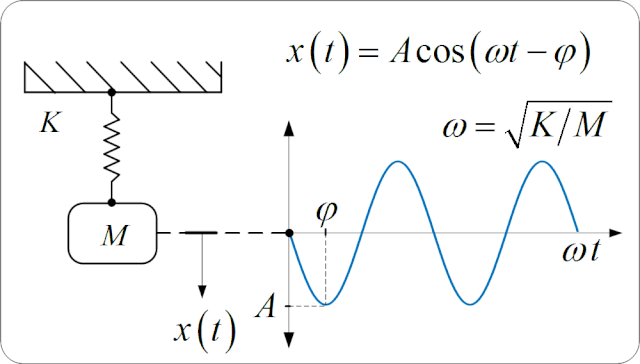
https://en.wikiversity.org/wiki/File:Mass_Spring_System_Undamped_case_Simple_harmonic_motion.gif

  

  
The equations of motion for a mass-spring system can be written as:

\begin{align*}  
m\frac{d^2x}{dt^2} = -kx\
\end{align*}

where  _m_ is the mass of the object, _k_ is the spring constant, and _x_ is the displacement of the mass from its equilibrium position.

We can convert this second-order ordinary differential equation into two first-order differential equations as follows:

\begin{align*}  
\frac{dx}{dt} = v \\
\end{align*}

\begin{align*}
\frac{dv}{dt} = -\frac{k}{m}x
\end{align*}

Here, _v_ is the velocity of the mass.



---



# 1) _METHODS IMPLEMENTATION_


__Verlet for Spring Motion:__  
The Verlet integration method is a numerical method used to solve ordinary differential equations (ODEs) such as those arising from physical systems. In this specific implementation for spring motion, the Verlet method is used to integrate the equations of motion for a spring-mass system. Here's a short introduction:

Given:

- \( k \): spring constant
- \( m \): mass
- \( dt \): time step
- \( tm \): total integration time
- \( x(t) \): position of the mass at time \( t \)
- \( v(t) \): velocity of the mass at time \( t \)

The Verlet method updates the position \( x(t) \) and velocity \( v(t) \) of the mass at each time step as follows:

Initialize \begin{align*}
t = 0 ,
x(t) = \text{initial_position},   v(t) = \text{initial_velocity}
\end{align*}
For each time step until \begin{align*} t = \text{tm} \end{align*}
_Loop:_        
>    Calculate acceleration \begin{align*} a(t) = -\frac{k}{m} x(t) \end{align*}
    Update position:
        \begin{align*}  x(t + dt) = 2x(t) - x(t - dt) + a(t) dt^2 \end{align*}
    Update velocity:
         \begin{align*} v(t + dt) = \frac{x(t + dt) - x(t - dt)}{2dt} \end{align*}
    Increment time: \begin{align*} t = t + dt \end{align*}

__Runge-Kutta 2nd Order Spring Motion:__   

The Runge-Kutta (RK2) method is another numerical integration method commonly used to solve ODEs. In this implementation, the RK2 method is used to integrate the equations of motion for a spring-mass system. Here's a brief description:

Given the same parameters as in the Verlet method, the RK2 method updates the position \( x(t) \) and velocity \( v(t) \) of the mass at each time step as follows:

Initialize \begin{align*} t = 0, x(t) = \text{initial_position}, v(t) = \text{initial_velocity}  \end{align*}
For each time step until \begin{align*} t = \text{tm} \end{align*}
_Loop:_  
>    Calculate acceleration  \begin{align*} a_1 = -\frac{k}{m} x(t) \end{align*}
    Calculate half-step values:
        \begin{align*} v_{\text{half}} = v(t) + \frac{1}{2} a_1 dt \end{align*}
        \begin{align*} x_{\text{half}} = x(t) + \frac{1}{2} v(t) dt \end{align*}
    Calculate acceleration at half-step: \begin{align*} a_2 = -\frac{k}{m} x_{\text{half}} \end{align*}
    Update position and velocity:
        \begin{align*} x(t + dt) = x(t) + v_{\text{half}} dt \end{align*}
        \begin{align*} v(t + dt) = v(t) + a_2 dt \end{align*}
    Increment time: \begin{align*} t = t + dt \end{align*}

Both methods are used to numerically solve the differential equation describing the spring-mass system, but they differ in their approaches to updating the position and velocity at each time step.

In [2]:
# @title #####__METHODS IMPLEMENTATION__

# VERLET INTEGRATION REFERENCE: https://www.youtube.com/watch?v=rT6Whl96N4g
@jit(nopython = True, looplift = True)
def verlet_spring_motion(k, m, dt, tm, initial_position, initial_velocity):

    t = [0]

    x = [initial_position]
    v = [initial_velocity]

    i = 0

    while t[-1] <= tm:

        a = -(k/m) * x[i]

        if i == 0:
            v_next = v[i] + a * dt
            x_next = x[i] + v_next * dt
        else:
            x_next = 2 * x[i] - x[i-1] + a * dt**2

        x.append(x_next)
        v.append(v_next)

        t.append(t[i] + dt)

        i += 1

    return np.array(t[:-1]), np.array(x[:-1]), np.array(v[:-1])


@jit(nopython = True, looplift = True)
def rk2_spring_motion(k, m, dt, tm, initial_position, initial_velocity):

    t = [0]
    x = [initial_position]
    v = [initial_velocity]

    while t[-1] <= tm:
        # Calculate k1
        a1 = -(k/m) * x[-1]
        v_half = v[-1] + 0.5 * a1 * dt
        x_half = x[-1] + 0.5 * v[-1] * dt

        # Calculate k2
        a2 = -(k/m) * x_half
        v_next = v[-1] + a2 * dt
        x_next = x[-1] + v_half * dt

        # Append results
        x.append(x_next)
        v.append(v_next)
        t.append(t[-1] + dt)

    return np.array(t[:-1]), np.array(x[:-1]), np.array(v[:-1])


@jit(nopython = True, looplift = True)
def explicit_euler_spring_motion(k, m, dt, tm, initial_position, initial_velocity):

    t = [0]

    x = [initial_position]
    v = [initial_velocity]

    while t[-1] <= tm:
        v_next = v[-1] - (k/m) * x[-1] * dt
        x_next = x[-1] + v[-1] * dt

        x.append(x_next)
        v.append(v_next)

        t.append(t[-1] + dt)

    return np.array(t[:-1]), np.array(x[:-1]), np.array(v[:-1])


def analytical_solution(k, m, dt, tm, initial_position, initial_velocity):
    omg = np.sqrt(k / m)
    t = np.arange(0, tm + dt, dt)
    xa = initial_position * np.cos(omg * t)

    return np.array(t), np.array(xa)

def calculate_error(x_computed, x_theory):
    x_end = len(x_computed)
    x_theory = x_theory[0:x_end]
    error = np.clip(np.abs(np.array(x_computed)-np.array(x_theory)), a_min=10**-9, a_max=100)
    return error

def calculate_error_w_sign(x_computed, x_theory):
    x_end = len(x_computed)
    x_theory = x_theory[0:x_end]
    error_w_sign = np.clip((np.array(x_computed)-np.array(x_theory)), a_min=10**-9, a_max=100)
    return error_w_sign

#-------------------------------------------------------------------------------
# EXTRA

def rk4_spring_motion(k, m, dt, tm, initial_position, initial_velocity):

    t = [0]

    x = [initial_position]
    v = [initial_velocity]

    while t[-1] <= tm:

        k1x = v[-1]
        k1v = -(k/m) * x[-1]

        k2x = v[-1] + 0.5 * dt * k1v
        k2v = -(k/m) * (x[-1] + 0.5 * dt * k1x)

        k3x = v[-1] + 0.5 * dt * k2v
        k3v = -(k/m) * (x[-1] + 0.5 * dt * k2x)

        k4x = v[-1] + dt * k3v
        k4v = -(k/m) * (x[-1] + dt * k3x)

        x_next = x[-1] + (dt / 6) * (k1x + 2*k2x + 2*k3x + k4x)
        v_next = v[-1] + (dt / 6) * (k1v + 2*k2v + 2*k3v + k4v)

        x.append(x_next)
        v.append(v_next)

        t.append(t[-1] + dt)

    return np.array(t[:-1]), np.array(x[:-1]), np.array(v[:-1])


In [3]:
# @title #####__PROBLEM PARAMS__

# Constants---------------------------------------------------------------------
k = 1       # Spring constant
m = 100     # Mass
dt = 0.01   # Time step [s]
tm = 2600   # Simulation time [s]

initial_position = 1    # Initial position
initial_velocity = 0    # Initial velocity

# 2) _RESULTS ANALYSIS_

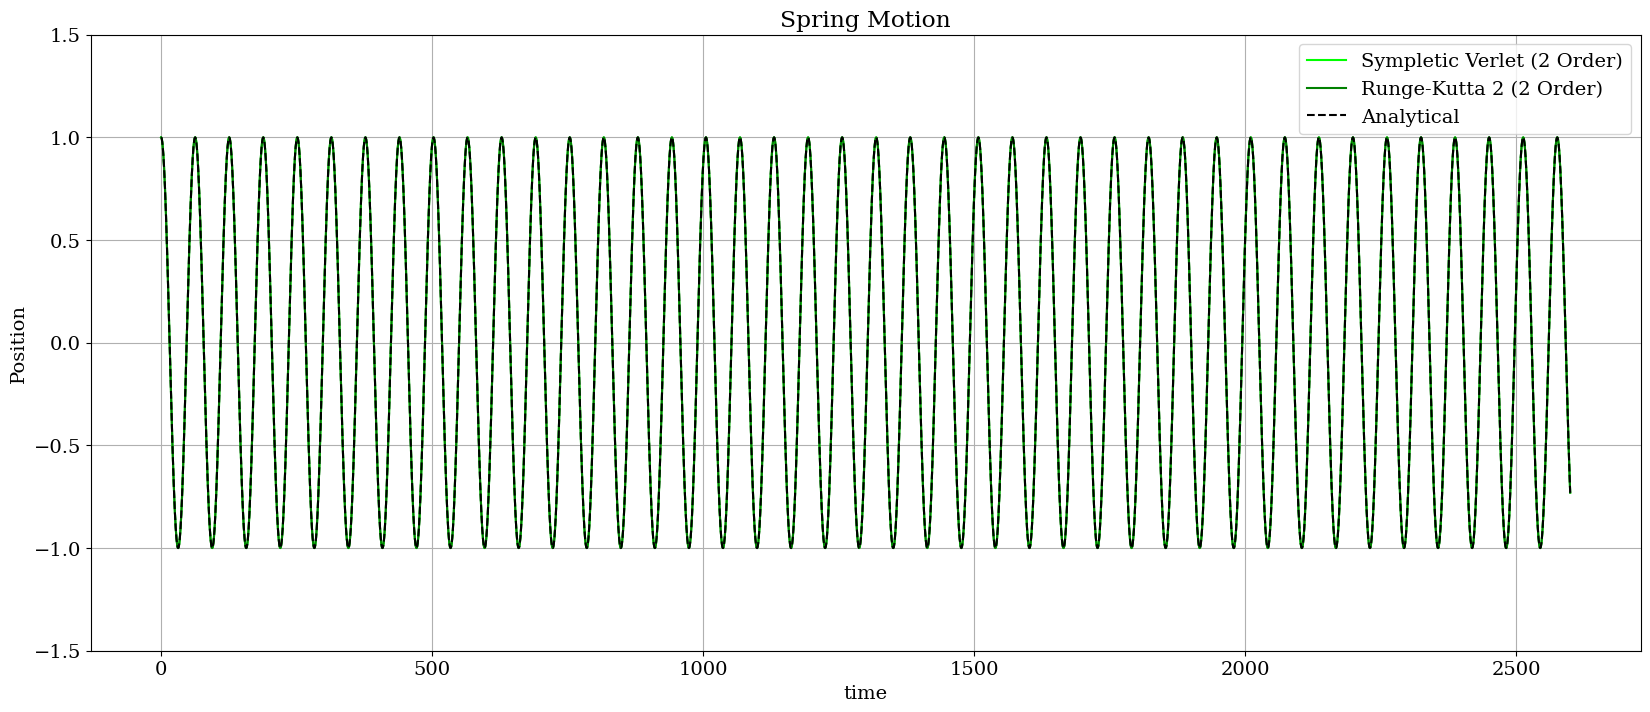

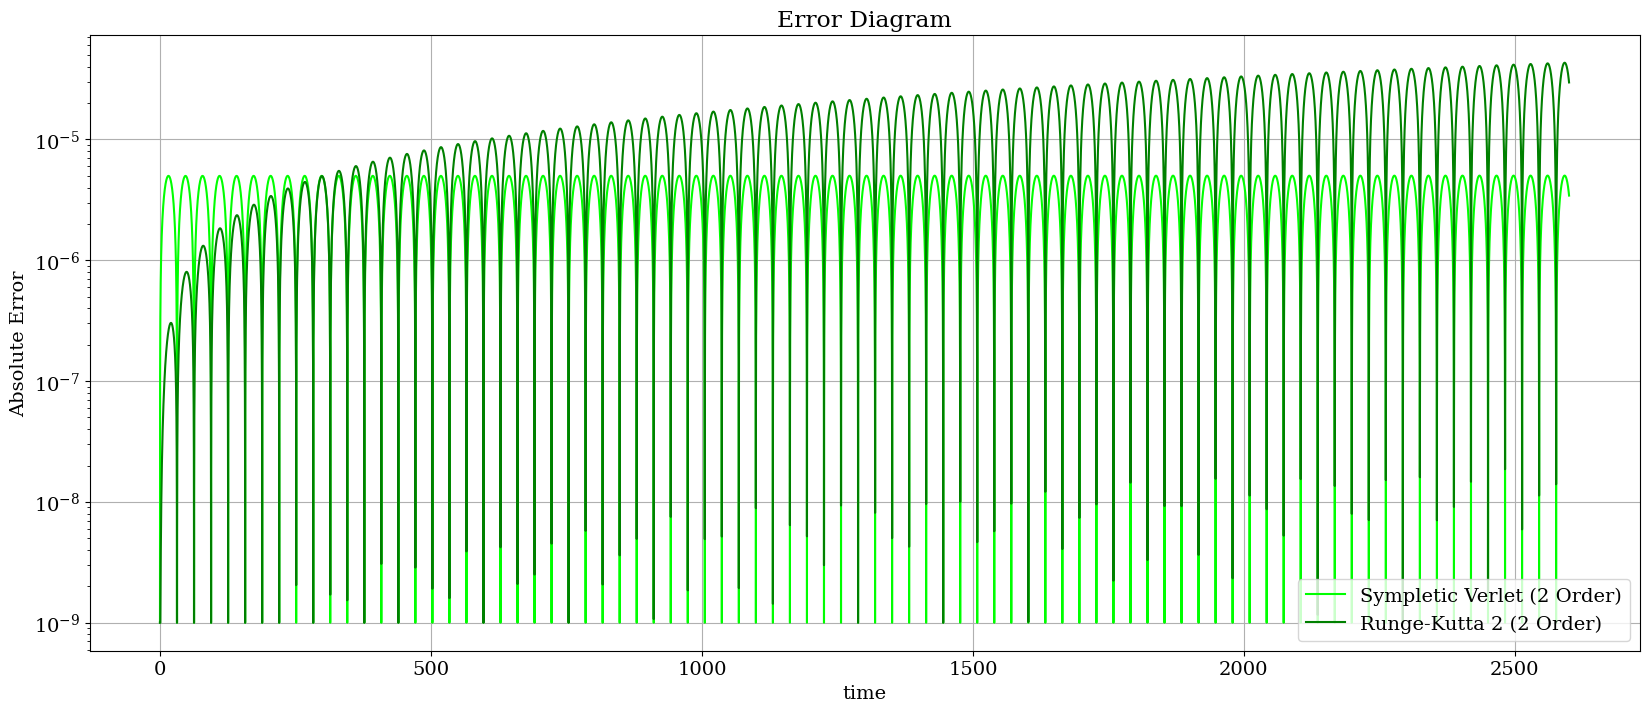

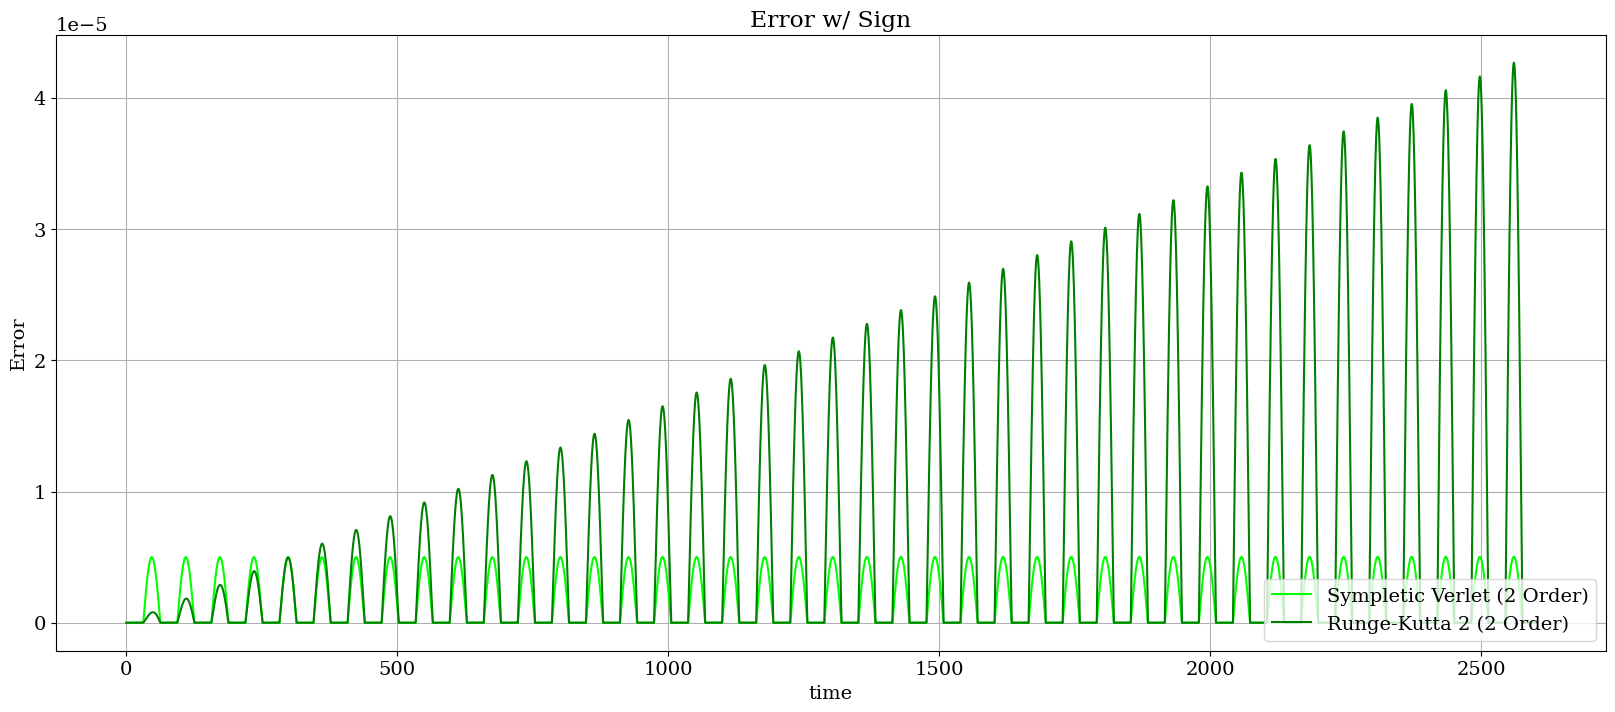

In [4]:
# @title #####__RESULTS & COMPARISON__

#-------------------------------------------------------------------------------
sympletic_dt = dt / 100

verlet_start = time.time()
t_verlet, x_verlet, v_verlet = verlet_spring_motion(k, m, sympletic_dt, tm, initial_position, initial_velocity)
verlet_end = time.time()

rk2_start = time.time()
t_rk2, x_rk2, v_rk2 = rk2_spring_motion(k, m, dt, tm, initial_position, initial_velocity)
rk2_end = time.time()

t_analytical, x_analytical = analytical_solution(k, m, dt, tm, initial_position, initial_velocity)

plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['text.usetex'] = False
plt.figure(figsize=(20, 8))
plt.plot(t_verlet, x_verlet, color='lime', label='Sympletic Verlet (2 Order)')
plt.plot(t_rk2, x_rk2, color='green', label='Runge-Kutta 2 (2 Order)')

plt.plot(t_analytical, x_analytical, color='black', label='Analytical',  linestyle='dashed')
plt.title('Spring Motion')
plt.xlabel('time')
plt.ylabel('Position')
plt.grid(True)
plt.ylim(-1.5, 1.5)
#plt.xlim(98, 100)
plt.legend(loc='upper right')
plt.show()

#-------------------------------------------------------------------------------

t_analytical_4sympletic, x_analytical_4sympletic = analytical_solution(k, m, sympletic_dt, tm, initial_position, initial_velocity)
verlet_err = calculate_error(x_verlet, x_analytical_4sympletic)
rk2_err = calculate_error(x_rk2, x_analytical)

plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['text.usetex'] = False
plt.figure(figsize=(20, 8))
plt.semilogy(t_verlet, verlet_err, color='lime', label='Sympletic Verlet (2 Order)')
plt.semilogy(t_rk2, rk2_err, color='green', label='Runge-Kutta 2 (2 Order)')

plt.title('Error Diagram')
plt.xlabel('time')
plt.ylabel('Absolute Error')
plt.grid(True)
#plt.xlim(98, 100)
plt.legend(loc='lower right')
plt.show()

del verlet_err, rk2_err

verlet_err_w_sign = calculate_error_w_sign(x_verlet, x_analytical_4sympletic)
rk2_err_w_sign = calculate_error_w_sign(x_rk2, x_analytical)

plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['text.usetex'] = False
plt.figure(figsize=(20, 8))
plt.plot(t_verlet, verlet_err_w_sign, color='lime', label='Sympletic Verlet (2 Order)')
plt.plot(t_rk2, rk2_err_w_sign, color='green', label='Runge-Kutta 2 (2 Order)')

plt.title('Error w/ Sign')
plt.xlabel('time')
plt.ylabel('Error')
plt.grid(True)
#plt.xlim(98, 100)
plt.legend(loc='lower right')
plt.show()

del verlet_err_w_sign, rk2_err_w_sign


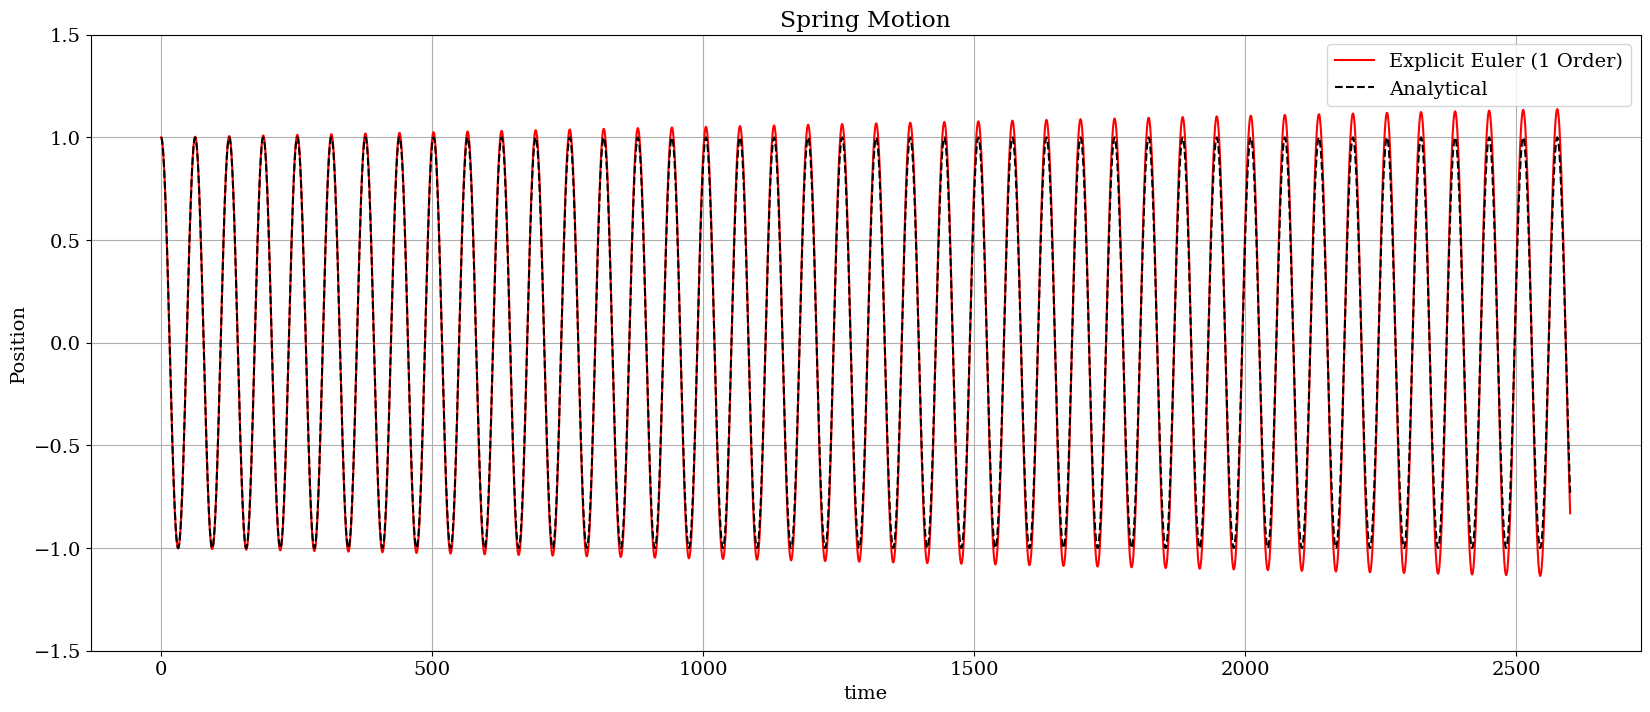

In [5]:
# @title #####__EXPLICIT EULER METHOD ON THE SPRING-MASS PROBLEM__

ee_start = time.time()
t_ee, x_ee, v_ee = explicit_euler_spring_motion(k, m, dt, tm, initial_position, initial_velocity)
ee_end = time.time()

plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['text.usetex'] = False
plt.figure(figsize=(20, 8))
plt.plot(t_ee, x_ee, color='red', label='Explicit Euler (1 Order)')
plt.plot(t_analytical, x_analytical, color='black', label='Analytical',  linestyle='dashed')
plt.title('Spring Motion')
plt.xlabel('time')
plt.ylabel('Position')
plt.grid(True)
plt.ylim(-1.5, 1.5)
#plt.xlim(98, 100)
plt.legend(loc='upper right')
plt.show()




From the reported results, it can be seen that the Verlet method and the RK2 method with the same order of accuracy exhibit different behaviour, and in particular RK2 over a long simulation run tends to deviate from the actual trajectory as if there were an external forcing acting on the system.   
The application of the explicit Euler method is shown to highlight this behaviour.




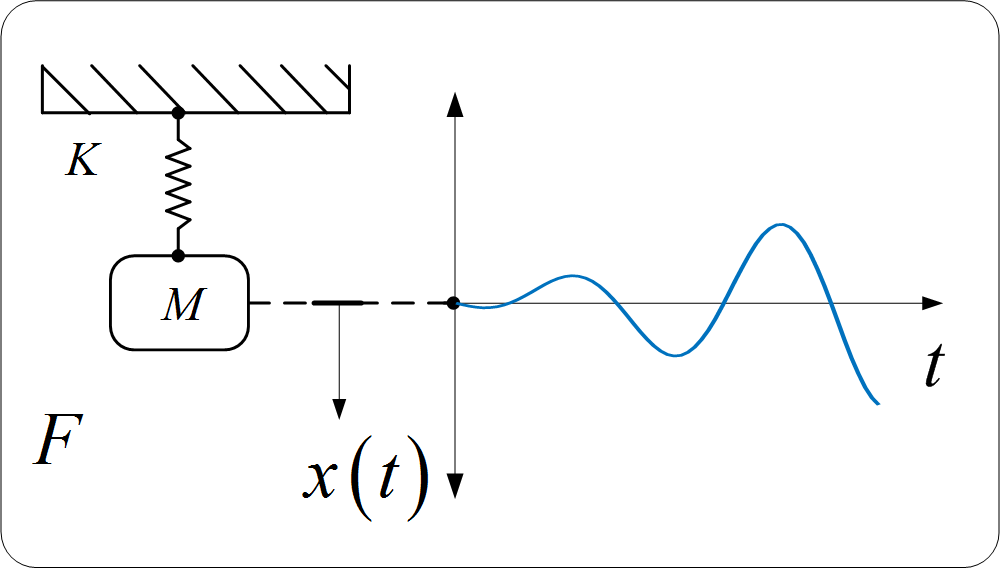
https://en.wikiversity.org/wiki/File:Mass_Spring_System_Resonance.gif  


The Verlet method is known for its ability to preserve energy in certain systems, particularly in conservative systems like those governed by Hamiltonian dynamics. This preservation of energy is a result of its symplectic nature, meaning it conserves the volume in phase space.

Mathematically, the Verlet method preserves energy in the following way:

Let \( E(x, v) \) represent the total energy of the system, which is a function of position \( x \) and velocity \( v \). In conservative systems, the total energy \( E \) is constant over time.

At each time step, the Verlet method updates the position \( x \) and velocity \( v \) according to the equations:

\begin{align*}  
x(t + dt) = 2x(t) - x(t - dt) + a(t) dt^2
\end{align*}

\begin{align*}
v(t + dt) = \frac{x(t + dt) - x(t - dt)}{2dt}
\end{align*}

Where:
- \( a(t) \) is the acceleration at time \( t \).
- \( dt \) is the time step.

The Verlet method essentially approximates the trajectory of the system using a Taylor expansion up to the second order. By doing so, it ensures that the system follows a reversible trajectory in phase space, which helps maintain the total energy of the system.

In summary, the Verlet method preserves energy by accurately approximating the trajectory of the system in phase space, ensuring that the system evolves in a way that conserves its total energy over time. This property makes it particularly useful for simulations of conservative systems.

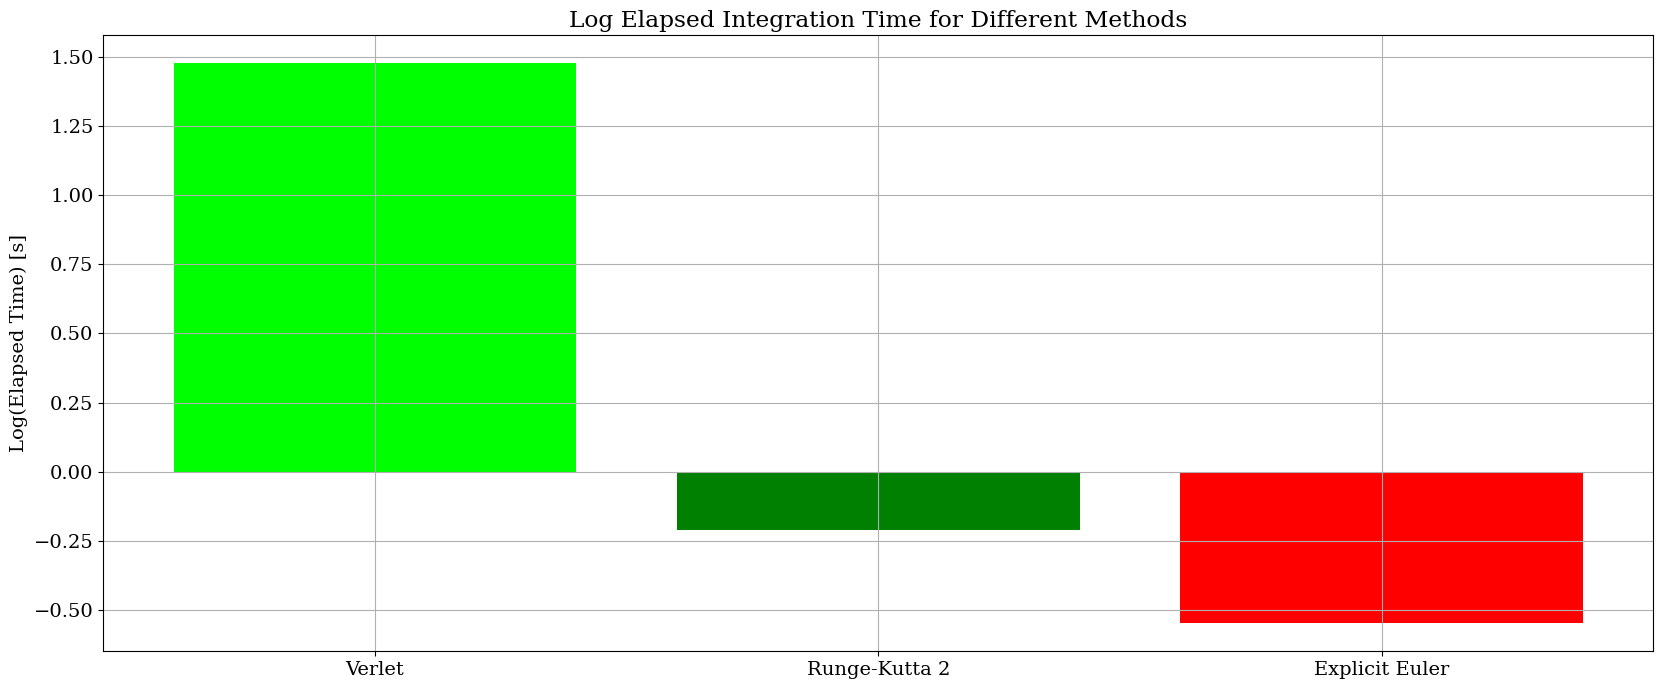

In [6]:
# @title #####__INTEGRATION TIME ORDER COMPARISON__

verlet_time = np.log(verlet_end - verlet_start)
rk2_time = np.log(rk2_end - rk2_start)
ee_time = np.log(ee_end - ee_start)

integration_times = [verlet_time, rk2_time, ee_time]
methods = ['Verlet', 'Runge-Kutta 2', 'Explicit Euler']

plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['text.usetex'] = False
plt.figure(figsize=(20, 8))
plt.bar(methods, integration_times, color=['lime', 'green', 'red'])
plt.ylabel('Log(Elapsed Time) [s]')
plt.title('Log Elapsed Integration Time for Different Methods')
plt.grid(True)
plt.show()

For completeness, the time taken by each solver to complete the simulation is reported.

Note that the symplectic method takes considerably longer, but a smaller integration step was used than the non-symplectic methods, such that the initial error is comparable so that effective comparisons can be made.